In [1]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't4_innerRadius',
    't4_outerRadius',
    't4_pt',
    't4_eta',
    't4_phi',
    't4_isFake',
    't4_t3_idx0',
    't4_t3_idx1',
    't4_pMatched',
    't4_sim_vxy',
    't4_sim_vz'
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't4_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "../../addT3DNN_noT4cut.root"
# file_path = "t4_PU200_175.root"
branches = load_root_file(file_path, branches_list)

In [2]:
z_max = np.max([np.max(event) for event in branches[f't4_t3_4_z'] if event.size>0])
r_max = np.max([np.max(event) for event in branches[f't4_t3_4_r'] if event.size>0])
eta_max = 2.5
phi_max = np.pi

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

def delta_phi(phi1, phi2):
    delta = phi1 - phi2
    # Adjust delta to be within the range [-pi, pi]
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    return delta

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [23]:
features_list = []
eta_list = [] # Used for DNN cut values

for event in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t4_t3_idx0'][event])

    for i in range(num_elements):
        features_iter = []
        eta_iter = []
        
        idx0 = branches['t4_t3_idx0'][event][i]
        idx1 = branches['t4_t3_idx1'][event][i]

        eta1 = np.abs(branches['t4_t3_0_eta'][event][idx0])
        eta2 = np.abs(branches['t4_t3_2_eta'][event][idx0])
        eta3 = np.abs(branches['t4_t3_4_eta'][event][idx0])
        eta4 = np.abs(branches['t4_t3_4_eta'][event][idx1])

        phi1 = (branches['t4_t3_0_phi'][event][idx0])
        phi2 = (branches['t4_t3_2_phi'][event][idx0])
        phi3 = (branches['t4_t3_4_phi'][event][idx0])
        phi4 = (branches['t4_t3_4_phi'][event][idx1])

        z1 = np.abs(branches['t4_t3_0_z'][event][idx0])
        z2 = np.abs(branches['t4_t3_2_z'][event][idx0])
        z3 = np.abs(branches['t4_t3_4_z'][event][idx0])
        z4 = np.abs(branches['t4_t3_4_z'][event][idx1])

        r1 = branches['t4_t3_0_r'][event][idx0]
        r2 = branches['t4_t3_2_r'][event][idx0]
        r3 = branches['t4_t3_4_r'][event][idx0]
        r4 = branches['t4_t3_4_r'][event][idx1]

        innerRad = branches['t4_innerRadius'][event][i]
        outerRad = branches['t4_outerRadius'][event][i]

        # Construct the input feature vector using pairwise differences
        features_iter = [
            eta1 / eta_max,                      # First hit eta, normalized
            # np.abs(phi1) / phi_max,              # First hit phi, normalized
            # z1 / z_max,                          # First hit z, normalized
            # r1 / r_max,                          # First hit r, normalized

            # eta2 - eta1,                         # Difference in eta between hit 2 and 1
            # delta_phi(phi2, phi1) / phi_max,     # Difference in phi between hit 2 and 1
            # (z2 - z1) / z_max,                   # Difference in z between hit 2 and 1, normalized
            # (r2 - r1) / r_max,                   # Difference in r between hit 2 and 1, normalized

            # eta3 - eta2,                         # Difference in eta between hit 3 and 2
            # delta_phi(phi3, phi2) / phi_max,     # Difference in phi between hit 3 and 2
            # (z3 - z2) / z_max,                   # Difference in z between hit 3 and 2, normalized
            # (r3 - r2) / r_max,                   # Difference in r between hit 3 and 2, normalized

            # eta4 - eta3,                         # Difference in eta between hit 4 and 3
            # delta_phi(phi4, phi3) / phi_max,     # Difference in phi between hit 4 and 3
            # (z4 - z3) / z_max,                   # Difference in z between hit 4 and 3, normalized
            # (r4 - r3) / r_max,                   # Difference in r between hit 4 and 3, normalized

            np.log10(innerRad),
            np.log10(outerRad),
            np.log10(innerRad/outerRad),
            # innerRad,
            # outerRad,
            # innerRad/outerRad,
        ]

        # Use the abs eta value of first hit to select cut thresholds
        eta_iter.extend([np.abs(branches['t4_t3_0_eta'][event][idx0])])
        
        # Append the feature vector to the list
        features_list.append(features_iter)
        eta_list.append(eta_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T
eta_list = np.array(eta_list).T

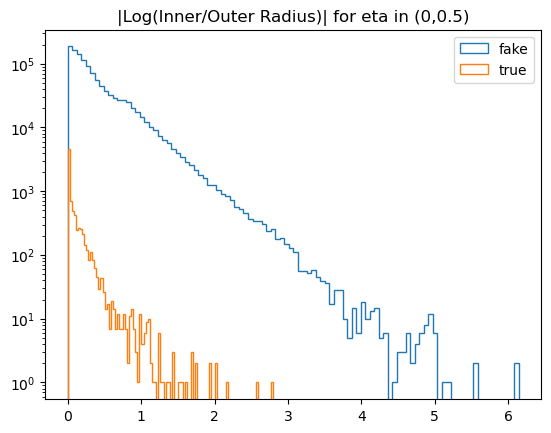

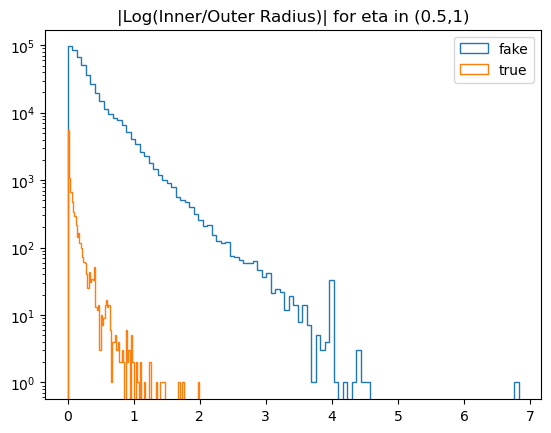

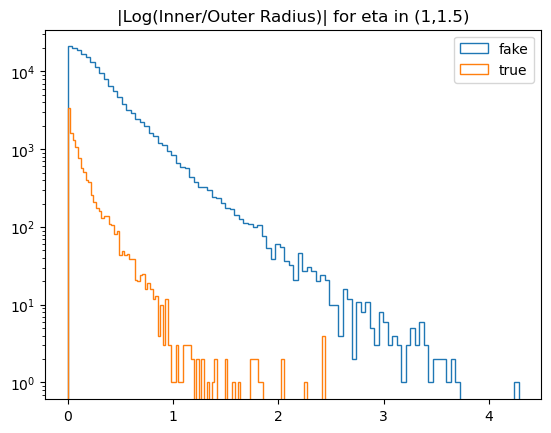

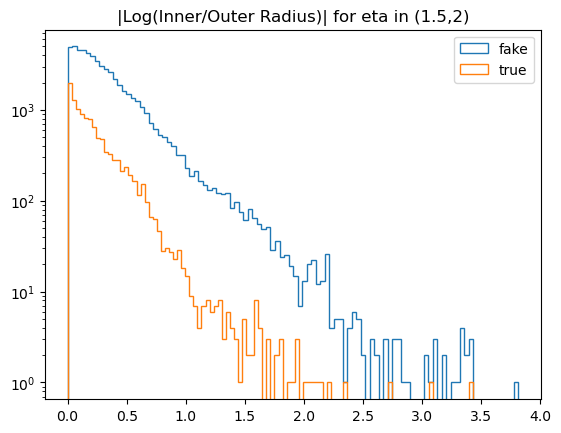

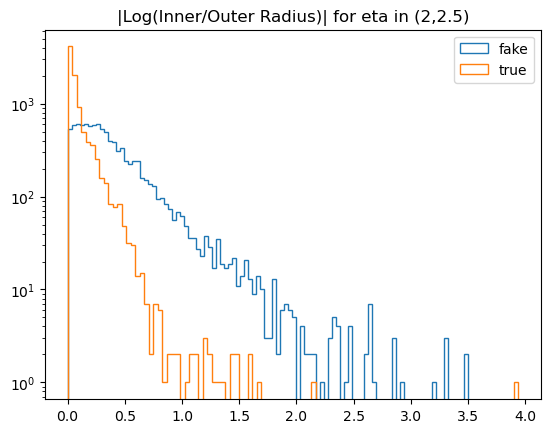

In [27]:
import matplotlib.pyplot as plt
def plot_feature(features, name, etamin, etamax):
    feature = features[3]
    etas = abs(np.concatenate(eta_list))
    fake_mask = np.concatenate(branches['t4_isFake']) ==1
    true_mask = np.concatenate(branches['t4_isFake']) ==0
    etamask = (etas>etamin)&(etas<etamax)
    fake_etamask = fake_mask&etamask
    true_etamask = true_mask&etamask

    plt.hist(abs(feature[fake_etamask]), bins=100, histtype='step', label='fake')
    plt.hist(abs(feature[true_etamask]), bins=100, histtype='step', label='true')
    plt.yscale('log')
    # plt.xlim( 500000)
    plt.title(f'{name}' + ' for eta in (' +  f'{etamin}'+','+f'{etamax}'+ ')')
    plt.legend()
    plt.show()

plot_feature(features, "|Log(Inner/Outer Radius)|", 0, .5 )
plot_feature(features, "|Log(Inner/Outer Radius)|", .5, 1 )
plot_feature(features, "|Log(Inner/Outer Radius)|", 1, 1.5 )
plot_feature(features, "|Log(Inner/Outer Radius)|", 1.5, 2 )
plot_feature(features, "|Log(Inner/Outer Radius)|", 2, 2.5 )


In [28]:
import torch

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t4_isFake_filtered = np.concatenate(branches['t4_isFake'])[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [29]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create labels tensor
labels_tensor = 1 - torch.tensor(t4_isFake_filtered, dtype=torch.float32)

# Set initial downsample fraction
initial_downsample_fraction = 1.0  # Adjust this value as needed


class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        # self.layer1 = nn.Linear(input_features_numpy.shape[1], 64) #increase width
        # self.layer2 = nn.Linear(64, 64) #increase width
        # self.layer3 = nn.Linear(64, 64) #add another hidden layer
        # self.layer4 = nn.Linear(64, 64) #add another hidden layer
        self.output_layer = nn.Linear(32, 1)
        # self.output_layer = nn.Linear(64, 1) #increase width

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        # x = self.layer3(x) #add another hidden layer
        # x = nn.ReLU()(x) #add another hidden layer
        # x = self.layer4(x) #add another hidden layer
        # x = nn.ReLU()(x) #add another hidden layer
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x
    
class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()
        
    def forward(self, outputs, targets, weights):
        eps = 1e-7
        losses = -(weights * (targets * torch.log(outputs + eps) + 
                            (1 - targets) * torch.log(1 - outputs + eps)))
        return losses.mean()

def calculate_sample_weights(t4_sim_vxy, weight_factor=6.0):
    """
    Calculate sample weights giving higher importance to displaced t5's
    
    Args:
        t4_sim_vxy: Array of t4 simulation values
        weight_factor: How much more weight to give to displaced samples
    
    Returns:
        Tensor of sample weights
    """
    weights = torch.ones(len(t4_sim_vxy))
    displaced_mask = t4_sim_vxy > 0.1
    weights[displaced_mask] = weight_factor
    return weights

# Print initial dataset size
print(f"Initial dataset size: {len(labels_tensor)}")

# Calculate sample weights
# sample_weights = calculate_sample_weights(torch.tensor(np.concatenate(branches['t4_sim_vxy'])))

# Remove rows with NaN and update weights accordingly
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]
# filtered_weights = sample_weights[~nan_mask]

# Initial downsampling of entire dataset
if initial_downsample_fraction < 1.0:
    total_samples = len(filtered_labels)
    samples_to_keep = int(total_samples * initial_downsample_fraction)
    indices = torch.randperm(total_samples)[:samples_to_keep]
    filtered_inputs = filtered_inputs[indices]
    filtered_labels = filtered_labels[indices]
    # filtered_weights = filtered_weights[indices]

print(f"Dataset size after initial {initial_downsample_fraction*100}% downsampling: {len(filtered_labels)}")

# Count samples in each class after initial downsampling
class_counts = torch.bincount(filtered_labels.int())
print(f"Class distribution after initial downsampling - Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

# Balance classes while maintaining weights
minority_class = 0 if class_counts[0] < class_counts[1] else 1
minority_indices = (filtered_labels == minority_class).nonzero(as_tuple=True)[0]
majority_indices = (filtered_labels == (1 - minority_class)).nonzero(as_tuple=True)[0]
downsampled_majority_indices = majority_indices[torch.randperm(len(majority_indices))[:len(minority_indices)]] #adjust downsample ratio

balanced_indices = torch.cat((minority_indices, downsampled_majority_indices))

# Create balanced dataset with weights
balanced_inputs = filtered_inputs[balanced_indices]
balanced_labels = filtered_labels[balanced_indices]
# balanced_weights = filtered_weights[balanced_indices]

# Verify balanced distribution
balanced_counts = torch.bincount(balanced_labels.int())
print(f"Final class distribution after balancing - Class 0: {balanced_counts[0]}, Class 1: {balanced_counts[1]}")

# Create dataset with weights
# dataset = TensorDataset(balanced_inputs, balanced_labels, balanced_weights) 
dataset = TensorDataset(balanced_inputs, balanced_labels)
# dataset = TensorDataset(filtered_inputs, filtered_labels) #no down sample

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)

# Initialize model and optimizer
model = MyNeuralNetwork().to(device)
# loss_function = weightedbceloss() #use when add weights
loss_function = nn.BCELoss() #unweighted
optimizer = Adam(model.parameters(), lr=0.0025)

def evaluate_model(loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        # for inputs, targets, weights in loader:
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += targets.size(0)
            correct += (predicted == targets.bool()).sum().item()
    model.train()
    return 100 * correct / total

# Training loop
num_epochs = 150
loss_log = []

for epoch in range(num_epochs):
    # for inputs, targets, weights in train_loader:
    for inputs, targets in train_loader:
        # inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
        inputs, targets = inputs.to(device), targets.to(device)

    
        # Forward pass
        outputs = model(inputs)
        # loss = loss_function(outputs.squeeze(), targets, weights)
        loss = loss_function(outputs.squeeze(), targets)
        
        loss_log.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_accuracy = evaluate_model(test_loader)
    # train_accuracy = evaluate_model(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Acc: {test_accuracy:.2f}%')

Using device: cuda
Initial dataset size: 1950003
Dataset size after initial 100.0% downsampling: 1950003
Class distribution after initial downsampling - Class 0: 1899404, Class 1: 50599
Final class distribution after balancing - Class 0: 50599, Class 1: 50599
Epoch [1/150], Loss: 0.5343, Test Acc: 79.32%
Epoch [2/150], Loss: 0.3533, Test Acc: 79.29%
Epoch [3/150], Loss: 0.3481, Test Acc: 79.36%
Epoch [4/150], Loss: 0.3749, Test Acc: 80.73%
Epoch [5/150], Loss: 0.4517, Test Acc: 80.96%
Epoch [6/150], Loss: 0.5166, Test Acc: 81.21%
Epoch [7/150], Loss: 0.3724, Test Acc: 80.60%
Epoch [8/150], Loss: 0.4266, Test Acc: 82.22%
Epoch [9/150], Loss: 0.4156, Test Acc: 82.68%
Epoch [10/150], Loss: 0.2967, Test Acc: 83.07%
Epoch [11/150], Loss: 0.4533, Test Acc: 83.56%
Epoch [12/150], Loss: 0.4564, Test Acc: 83.92%
Epoch [13/150], Loss: 0.4184, Test Acc: 83.99%
Epoch [14/150], Loss: 0.3565, Test Acc: 84.25%
Epoch [15/150], Loss: 0.2927, Test Acc: 84.25%
Epoch [16/150], Loss: 0.4045, Test Acc: 84.5

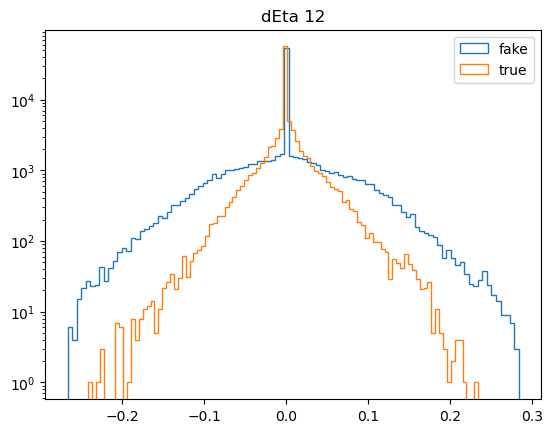

In [8]:
# class_counts = torch.bincount(filtered_labels.int())
# print(f"Class distribution after initial downsampling - Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

# # Balance classes while maintaining weights
# minority_class = 0 if class_counts[0] < class_counts[1] else 1
# minority_indices = (filtered_labels == minority_class).nonzero(as_tuple=True)[0]
# majority_indices = (filtered_labels == (1 - minority_class)).nonzero(as_tuple=True)[0]
# downsampled_majority_indices = majority_indices[torch.randperm(len(majority_indices))[:len(minority_indices)]]

# balanced_indices = torch.cat((minority_indices, downsampled_majority_indices))

# balanced_inputs = filtered_inputs[balanced_indices]
# balanced_labels = filtered_labels[balanced_indices]
# # balanced_weights = filtered_weights[balanced_indices]

# # Verify balanced distribution
# balanced_counts = torch.bincount(balanced_labels.int())
# print(f"Final class distribution after balancing - Class 0: {balanced_counts[0]}, Class 1: {balanced_counts[1]}")


# plotting for feature check 
# balanced_labels
fakes= (balanced_inputs.squeeze() *(balanced_labels==0))
trues = (balanced_inputs.squeeze()*(balanced_labels ==1))

plt.hist(fakes, bins=100, histtype='step', label='fake')
plt.hist(trues, bins=100, histtype='step', label='true')
plt.yscale('log')
plt.title('dEta 12')
# plt.xlim(0,40000)
plt.legend()
plt.show()

In [30]:
torch.save(model.state_dict(), "model.pth")

In [31]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    model.eval()  # Set the model to evaluation mode
    inputs = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.8428058624267578
Feature importances:
Feature 0 importance: 0.0168
Feature 1 importance: 0.0073
Feature 3 importance: 0.0071
Feature 2 importance: -0.0012


/tmp/ipykernel_4182859/1073338706.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


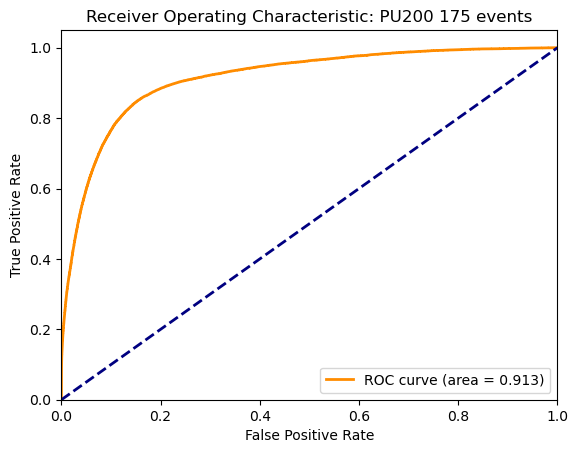

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic: PU200 175 events')
plt.legend(loc="lower right")
plt.show()

In [10]:
import pandas as pd

# Assuming your features are in the PyTorch tensor `input_features_tensor`
# Example: 
# input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

# Step 1: Convert the PyTorch tensor to a NumPy array
input_features_numpy = input_features_tensor.numpy()

# Step 2: Convert the NumPy array to a Pandas DataFrame
features_df = pd.DataFrame(input_features_numpy, columns=[f'feature_{i}' for i in range(input_features_numpy.shape[1])])

# Step 3: Compute the correlation matrix using Pandas
correlation_matrix = features_df.corr()

# Step 4: Display the correlation matrix
print(correlation_matrix)

            feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
feature_0    1.000000  -0.003232   0.928628   0.004118  -0.065989  -0.001514   
feature_1   -0.003232   1.000000  -0.004055  -0.003316   0.002602  -0.001679   
feature_2    0.928628  -0.004055   1.000000   0.233442  -0.037698  -0.003055   
feature_3    0.004118  -0.003316   0.233442   1.000000   0.045828  -0.007697   
feature_4   -0.065989   0.002602  -0.037698   0.045828   1.000000  -0.001771   
feature_5   -0.001514  -0.001679  -0.003055  -0.007697  -0.001771   1.000000   
feature_6    0.775352  -0.002093   0.731514   0.079388   0.500814  -0.003099   
feature_7   -0.266138  -0.001339  -0.195110   0.506253   0.041073   0.001852   
feature_8   -0.162206   0.004162  -0.124222   0.022007   0.689029  -0.005534   
feature_9   -0.004220   0.004084  -0.006744  -0.011364  -0.001587   0.809672   
feature_10   0.756174  -0.001710   0.707938   0.050655   0.403042  -0.004512   
feature_11  -0.202128   0.001214  -0.186

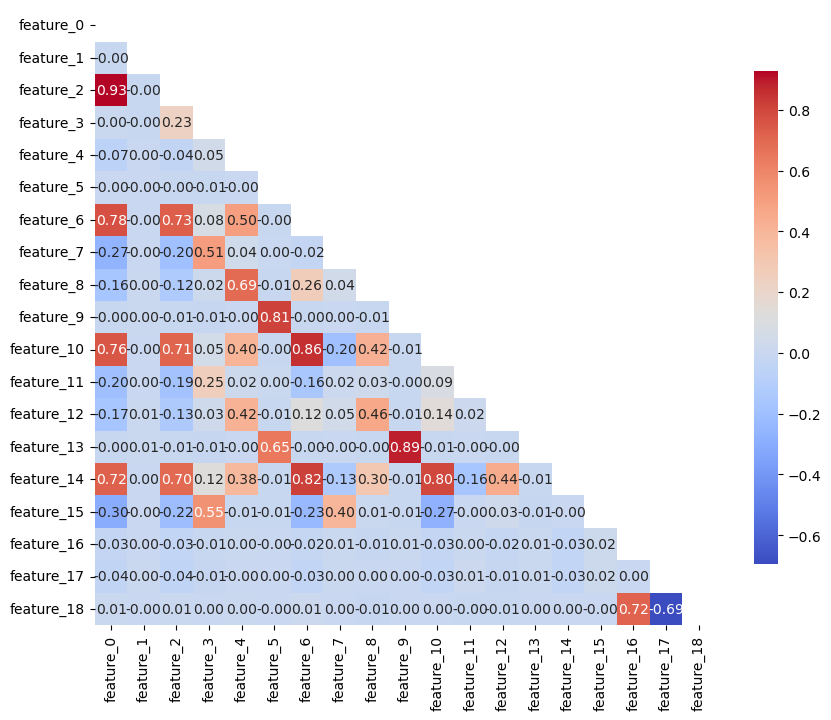

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'shrink': 0.8})

# Display the plot
plt.show()

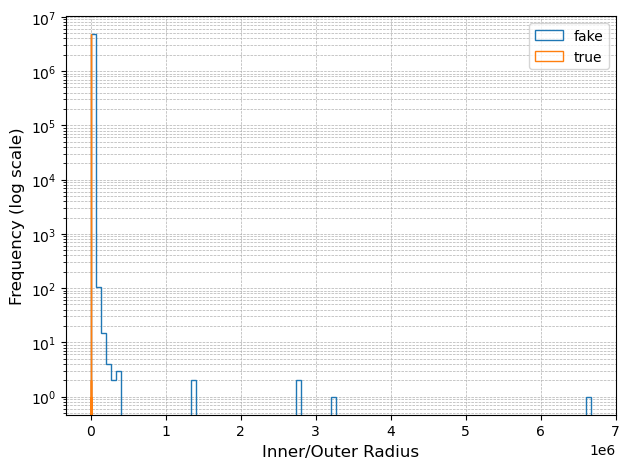

In [52]:

def plot_features(features):
    fake_mask = t4_isFake_filtered
    perfect_mask = (t4_isFake_filtered == 0)* (np.concatenate(branches['t4_pMatched']) > 0.95)
    plt.hist(features, bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
    # plt.hist(features[perfect_mask], bins=100, histtype='step', linewidth=1.5, label='100% match')  # Outline only, no fill
    plt.yscale('log')
    plt.xlabel("Inner/Outer Radius", fontsize=12)
    plt.ylabel("Frequency (log scale)", fontsize=12)
    # plt.title("DNN Score", fontsize=14, weight='bold')
    plt.legend()

    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# plot_features(features)

rad_rat_fake=( np.concatenate(branches['t4_isFake']) == 1)* ((np.concatenate(branches['t4_innerRadius'])/np.concatenate(branches['t4_outerRadius'])))
rad_rat_true = ( np.concatenate(branches['t4_isFake']) == 0)* ((np.concatenate(branches['t4_innerRadius'])/np.concatenate(branches['t4_outerRadius']))) 
plt.hist(rad_rat_fake, bins=100,histtype='step', label="fake")
plt.hist(rad_rat_true, bins=100, histtype='step', label="true")
plt.yscale('log')
plt.xlabel("Inner/Outer Radius", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
    # plt.title("DNN Score", fontsize=14, weight='bold')
plt.legend()
# plt.xlim(0,50000)

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Prediction scores:
Mean score: 0.1899
Median score: 0.0984


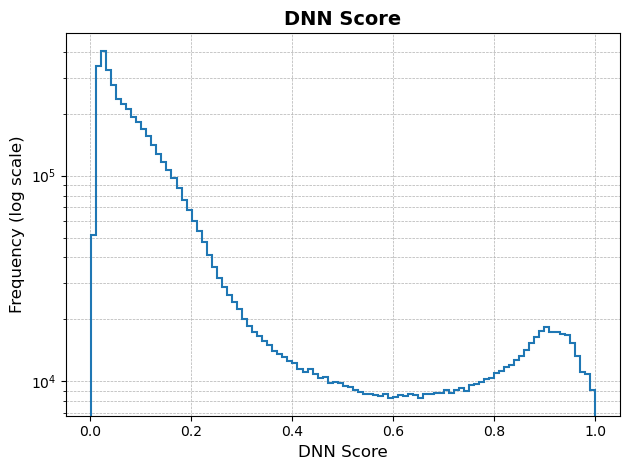

In [21]:
# Get model predictions
# probabilities = model_outputs(filtered_inputs, model)



# Calculate statistics for displaced tracks
mean_score = np.mean(probabilities)
median_score = np.median(probabilities)

print(f"Prediction scores:")
print(f"Mean score: {mean_score:.4f}")
print(f"Median score: {median_score:.4f}")

plt.hist(probabilities, bins=100, histtype='step', linewidth=1.5)  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score", fontsize=14, weight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

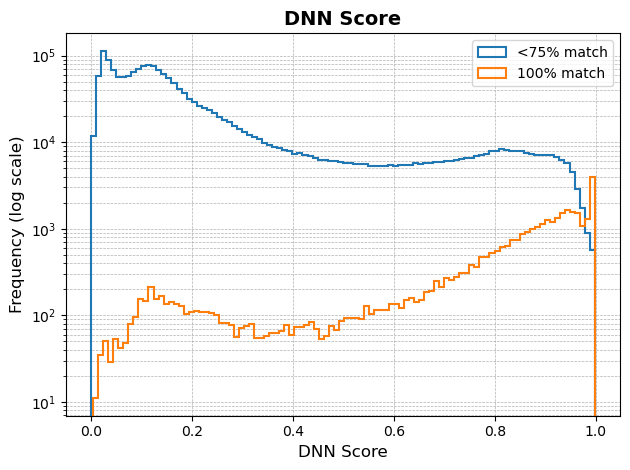

In [33]:
fake_mask = np.concatenate(branches['t4_isFake'])[~nan_mask] == 1
perfect_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 0)* (np.concatenate(branches['t4_pMatched']) > 0.95)
plt.hist(probabilities[fake_mask], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.hist(probabilities[perfect_mask], bins=100, histtype='step', linewidth=1.5, label='100% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


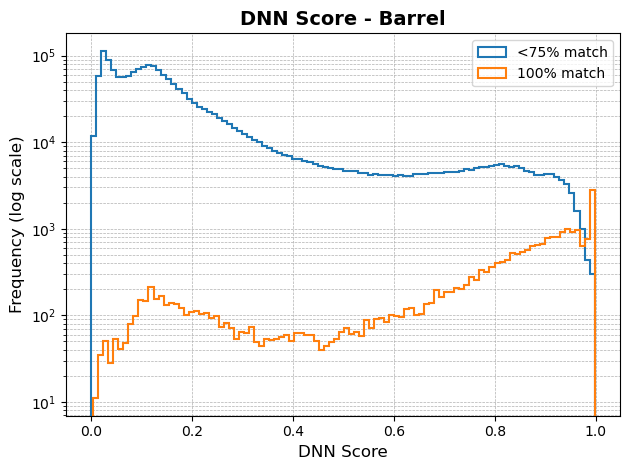

In [34]:
barrel_fake_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 1)*(np.concatenate(branches['t4_eta'])<1)
barrel_perfect_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 0)* (np.concatenate(branches['t4_pMatched']) > 0.95)*(np.concatenate(branches['t4_eta'])<1)
plt.hist(probabilities[barrel_fake_mask], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.hist(probabilities[barrel_perfect_mask], bins=100, histtype='step', linewidth=1.5, label='100% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score - Barrel", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

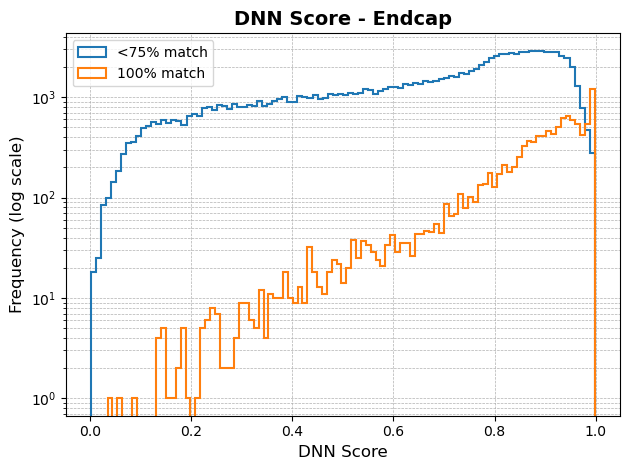

In [35]:
endcap_fake_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 1)*(np.concatenate(branches['t4_eta'])>1)
endcap_perfect_mask = (np.concatenate(branches['t4_isFake'])[~nan_mask] == 0)* (np.concatenate(branches['t4_pMatched']) > 0.95)*(np.concatenate(branches['t4_eta'])>1)
plt.hist(probabilities[endcap_fake_mask], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.hist(probabilities[endcap_perfect_mask], bins=100, histtype='step', linewidth=1.5, label='100% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score - Endcap", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [36]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)


ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_layer1[32] = {
-0.8610055f, 0.2214821f, -0.5221643f, 0.0481074f, 0.0616194f, -0.0367941f, 0.1156355f, -0.2432265f, -0.1224042f, 0.4423156f, 0.1176957f, 0.0502357f, 0.5220652f, 0.0628659f, 0.8641768f, 0.0961355f, 0.0455163f, 0.1102705f, -0.0827222f, -0.1265777f, 0.0943207f, -0.4470991f, 0.0289159f, -0.0966213f, 0.3305981f, 0.1617409f, -0.3838702f, 0.1091866f, 0.4530079f, 0.4779634f, -0.2672839f, -0.4977239f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_layer1[4][32] = {
{ -1.2837853f, -1.2836313f, 0.4412507f, 0.2480189f, 0.7739758f, 0.0238542f, -0.3353790f, 1.0100485f, 0.1444376f, -0.3624799f, 0.7346962f, -0.1642461f, -0.7880895f, -0.0449904f, 0.2776355f, -0.5860550f, 0.1958218f, 1.2086570f, 0.0946741f, -0.7965929f, 0.9250238f, 0.5524056f, -0.1052539f, -0.3407350f, 0.3808020f, 0.1850280f, 0.2306523f, 0.0844379f, -0.1738804f, -1.1733567f, -0.6672762f, -0.4285604f },
{ 0.6246983f, 0.3856818f, 0.1442273f, -0.2762086f, -0.4135527f, -0.223370

In [37]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to(device)

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()

full_tracks = (np.concatenate(branches['t4_isFake']) == 0) * (np.concatenate(branches['t4_pMatched']) > 0.95)


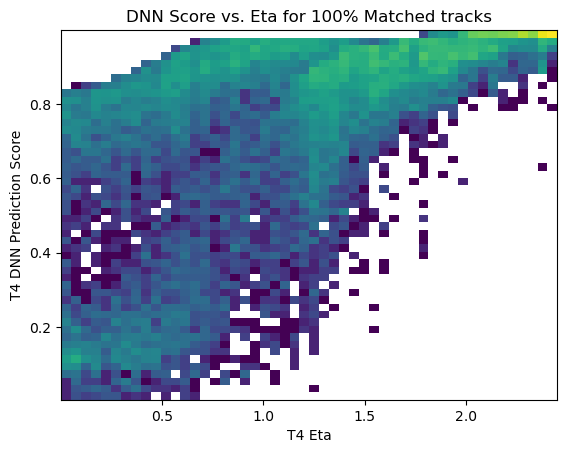

In [38]:
from matplotlib.colors import LogNorm

# full_tracks =  (np.concatenate(branches['t4_pMatched']) > 0.95) 
plt.hist2d(eta_list[0][full_tracks], predictions[full_tracks], bins=[50,50], norm=LogNorm())
plt.xlabel("T4 Eta")
plt.ylabel("T4 DNN Prediction Score")
plt.title("DNN Score vs. Eta for 100% Matched tracks")
# plt.colorbar()
plt.show()

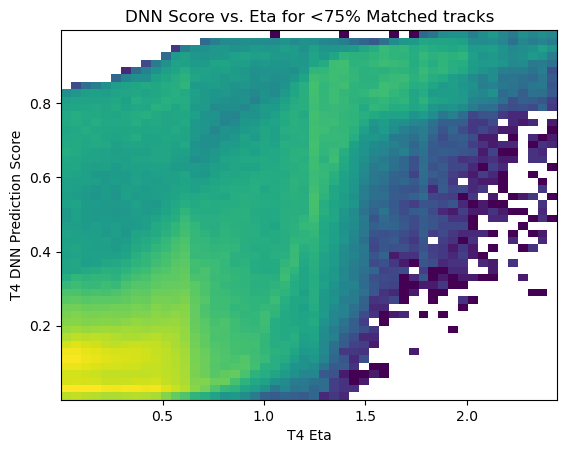

In [39]:
from matplotlib.colors import LogNorm
fake_tracks = (np.concatenate(branches['t4_isFake']) ==1) 
# full_tracks =  (np.concatenate(branches['t4_pMatched']) > 0.95) 
plt.hist2d(eta_list[0][fake_tracks], predictions[fake_tracks], bins=[50,50], norm=LogNorm())
plt.xlabel("T4 Eta")
plt.ylabel("T4 DNN Prediction Score")
plt.title("DNN Score vs. Eta for <75% Matched tracks")
# plt.colorbar()
plt.show()

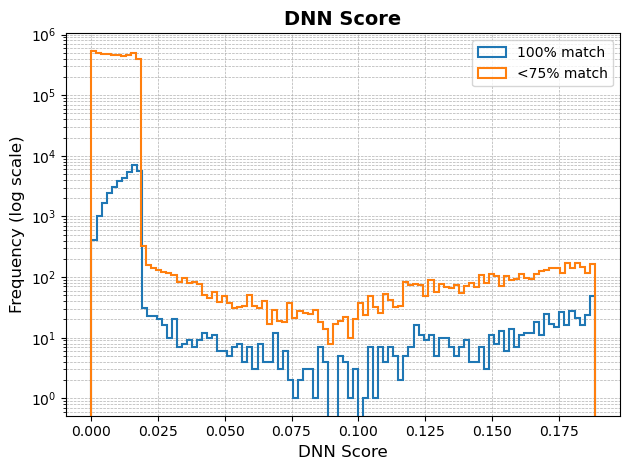

In [17]:
# mean_score = np.mean(probabilities)
# median_score = np.median(probabilities)

# print(f"Prediction scores:")
# print(f"Mean score: {mean_score:.4f}")
# print(f"Median score: {median_score:.4f}")

plt.hist(predictions[full_tracks], bins=100, histtype='step', linewidth=1.5, label='100% match')
plt.hist(predictions[fake_tracks], bins=100, histtype='step', linewidth=1.5, label='<75% match')  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score", fontsize=14, weight='bold')
plt.legend()

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

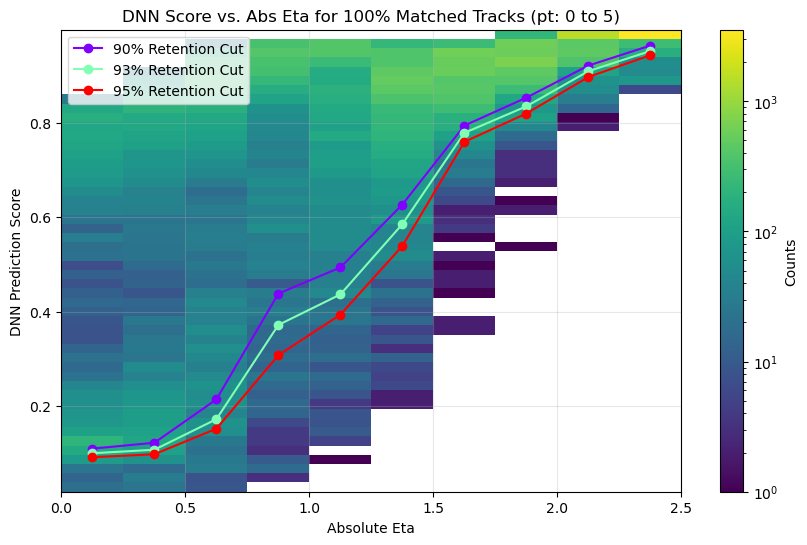


pt: 0 to 5
90% Retention Cut: {0.1095, 0.122, 0.2139, 0.4384, 0.4938, 0.6273, 0.7947, 0.854, 0.922, 0.9645} Mean: 0.554
93% Retention Cut: {0.0997, 0.1072, 0.172, 0.3719, 0.4366, 0.5858, 0.7792, 0.8355, 0.9101, 0.953} Mean: 0.5251
95% Retention Cut: {0.0912, 0.0976, 0.1518, 0.3077, 0.3936, 0.5394, 0.7602, 0.8203, 0.8977, 0.9441} Mean: 0.5004


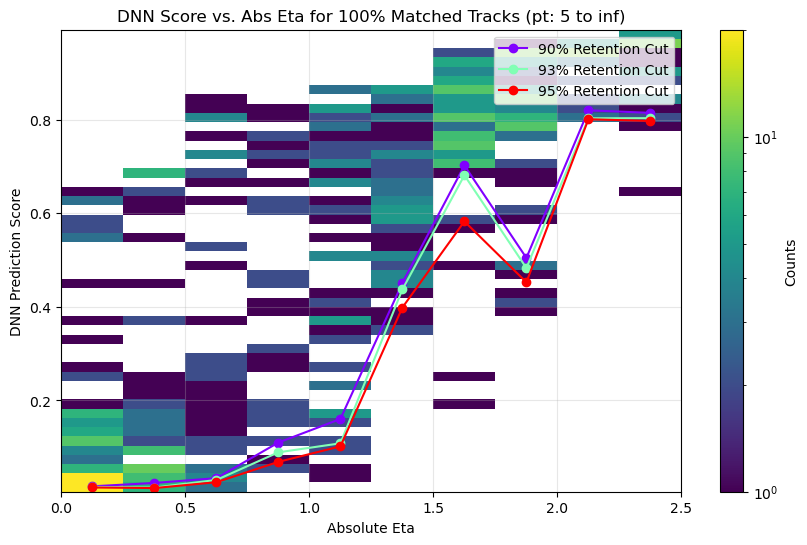


pt: 5 to inf
90% Retention Cut: {0.0165, 0.0237, 0.034, 0.11, 0.1604, 0.4511, 0.7018, 0.5043, 0.8196, 0.8142} Mean: 0.3635
93% Retention Cut: {0.0153, 0.0137, 0.0301, 0.0891, 0.1084, 0.4371, 0.6809, 0.4828, 0.8026, 0.8028} Mean: 0.3463
95% Retention Cut: {0.014, 0.0128, 0.0253, 0.0687, 0.1019, 0.3984, 0.5824, 0.4523, 0.8006, 0.7968} Mean: 0.3253


In [40]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin
    
    Parameters:
    -----------
    pt_min : float
        Minimum pt value for the bin
    pt_max : float
        Maximum pt value for the bin
    percentiles : list
        List of percentiles to calculate (e.g., [92.5, 96.7, 99])
    eta_bin_edges : array
        Edges of the eta bins
    eta_list : list
        List of eta values
    predictions : array
        Array of DNN predictions
    full_tracks : array
        Boolean array for track selection
    branches : dict
        Dictionary containing branch data
    """
    # Filter data based on pt bin
    abs_eta = eta_list[0][full_tracks & (np.concatenate(branches['t4_pt']) > pt_min) & 
                         (np.concatenate(branches['t4_pt']) <= pt_max)]
    predictions_filtered = predictions[full_tracks & (np.concatenate(branches['t4_pt']) > pt_min) & 
                                    (np.concatenate(branches['t4_pt']) <= pt_max)]
    
    # Dictionary to store cut values for different percentiles
    cut_values = {p: [] for p in percentiles}

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        for percentile in percentiles:
            cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
            cut_values[percentile].append(cut_value)

    # Plot 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values with different colors
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
    for percentile, color in zip(percentiles, colors):
        plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
                label=f'{percentile}% Retention Cut')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print the cut values
    print(f"\npt: {pt_min} to {pt_max}")
    for percentile in percentiles:
        values = cut_values[percentile]
        print(f"{percentile}% Retention Cut:", 
              '{' + ', '.join(str(x) for x in np.round(values, 4)) + '}',
              "Mean:", np.round(np.mean(values), 4))

# Example usage:
def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Analyze and plot for multiple pt bins and percentiles
    
    Parameters:
    -----------
    pt_bins : list
        List of pt bin edges
    percentiles : list
        List of percentiles to calculate
    Other parameters same as plot_for_pt_bin function
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
                       eta_list, predictions, full_tracks, branches)

# Example call:
percentiles = [90, 93, 95]
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)
analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches)

Prediction scores for displaced tracks (t4_sim_vxy > 0.1):
Mean score: 0.8087
Median score: 0.8811


/tmp/ipykernel_4182859/1073338706.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


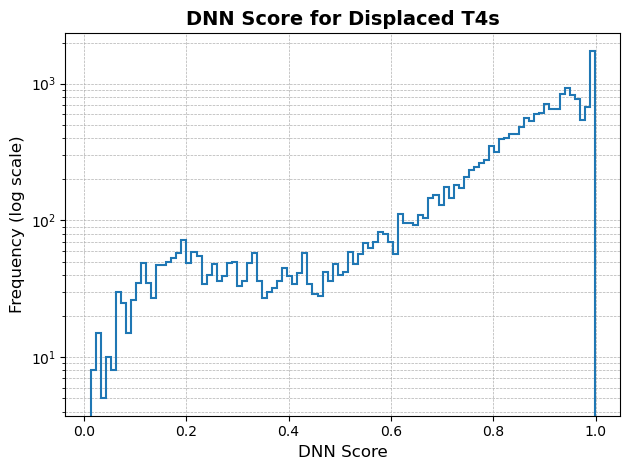

In [41]:
# Get model predictions
probabilities = model_outputs(filtered_inputs, model)

# Get displaced track mask
displaced_mask = np.concatenate(branches['t4_sim_vxy'])[~nan_mask] > 0.1

# Calculate statistics for displaced tracks
displaced_predictions = probabilities[displaced_mask]
mean_score = np.mean(displaced_predictions)
median_score = np.median(displaced_predictions)

print(f"Prediction scores for displaced tracks (t4_sim_vxy > 0.1):")
print(f"Mean score: {mean_score:.4f}")
print(f"Median score: {median_score:.4f}")

plt.hist(displaced_predictions, bins=100, histtype='step', linewidth=1.5)  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score for Displaced T4s", fontsize=14, weight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()